In [1]:
###Dependencies
from bs4 import BeautifulSoup
import requests
import pandas as pd
from datetime import datetime, date, time, timedelta
import re
import warnings
import statsmodels.api as sm
import random
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [3]:
def get_data(page_num, minScore=0, maxScore=10):
   

	url = f"https://onebite.app/reviews/dave?page={page_num}&{minScore}&{maxScore}"

	r = requests.get(url)
	html = r.text

	soup = BeautifulSoup(html, 'html.parser')


	all_reviews = soup.find_all('div', class_='jsx-596798944 col col--review')


	reviews = {}


	for review in all_reviews:
		score = float(review.find('p', class_="jsx-845469894 rating__score").text)
		title = str(review.find('h2', class_="jsx-574827726 reviewCard__title").text)
		location = str(review.find('p', class_="jsx-574827726 reviewCard__location").text)
		timestamp = str(review.find('p', class_="jsx-2368882028 userMeta__timestamp").text)

		reviews.setdefault('score', []).append(score)
		reviews.setdefault('title', []).append(title)
		reviews.setdefault('location', []).append(location)
		reviews.setdefault('timestamp', []).append(timestamp)

	return reviews


In [4]:
#Aggregates reivews for each page 
df_list = []
for i in list(range(0,100)):
    df = pd.DataFrame(get_data(i))
    df_list.append(df)
    
review_df = pd.concat(df_list)

In [5]:
#Split city and state
review_df['city'], review_df['state'] = review_df['location'].str.split(',', 1).str
review_df

,score,title,location,timestamp,city,state
0,6.8,Pizza Time Restaurant,"Avenel, NJ",3/18/20 10:02 PM,Avenel,NJ
1,8.8,Nancy's Towne House,"Rahway, NJ",3/17/20 10:00 PM,Rahway,NJ
2,6.8,Frankie Feds,"Freehold, NJ",3/16/20 10:00 PM,Freehold,NJ
3,7.4,Romeo's,"Freehold, NJ",3/13/20 10:00 PM,Freehold,NJ
4,7.2,Dusal's Italian Restaurant,"Freehold, NJ",3/12/20 10:00 PM,Freehold,NJ
...,...,...,...,...,...,...
13,8.2,Bianchi's Pizza,"Revere, MA",4/9/13 4:00 PM,Revere,MA
14,8.5,Tony's Place,"West Roxbury, MA",4/3/13 4:00 PM,West Roxbury,MA
15,8.5,Cape Cod Cafe,"Brockton, MA",4/2/13 4:00 PM,Brockton,MA
16,8.0,Lynwood Cafe,"Randolph, MA",3/14/13 6:00 PM,Randolph,MA


In [6]:
#replace "days ago" values
today = datetime.today()

reformat_dates = review_df.loc[review_df['timestamp'].str.contains('days ago')].reset_index()
reformat_dates['days'] = [re.findall('\d', row)[0] for row in reformat_dates['timestamp']]
reformat_dates['timestamp'] = [today - timedelta(days=int(delta)) for delta in reformat_dates['days']]
reformat_dates.drop(['days', 'index'], axis=1, inplace = True)

reformat_dates

,score,title,location,timestamp,city,state


In [7]:
#replace "hours ago" values
today = datetime.today()

reformat_hours = review_df.loc[review_df['timestamp'].str.contains('hours ago')].reset_index()
reformat_hours['timestamp'] = today 
reformat_hours.drop('index', axis=1, inplace = True)

reformat_hours

,score,title,location,timestamp,city,state


In [8]:
#Creating dt column
change_format = review_df.loc[~review_df['timestamp'].str.contains('ago')]
change_format['timestamp'] = pd.to_datetime(change_format['timestamp'])

In [9]:
#Appending hours, days ago to main review_df
review_df = change_format.append([reformat_dates, reformat_hours])

In [10]:
#Dropping duplicate entry
review_df.drop_duplicates(inplace=True)

In [11]:
#Strip out whitespace
review_df['state'] = [row.strip() for row in review_df['state']]
review_df['city'] = [row.strip() for row in review_df['city']]

In [12]:
review_df.sort_values('timestamp', ascending=False)

,score,title,location,timestamp,city,state
0,6.8,Pizza Time Restaurant,"Avenel, NJ",2020-03-18 22:02:00,Avenel,NJ
1,8.8,Nancy's Towne House,"Rahway, NJ",2020-03-17 22:00:00,Rahway,NJ
2,6.8,Frankie Feds,"Freehold, NJ",2020-03-16 22:00:00,Freehold,NJ
3,7.4,Romeo's,"Freehold, NJ",2020-03-13 22:00:00,Freehold,NJ
4,7.2,Dusal's Italian Restaurant,"Freehold, NJ",2020-03-12 22:00:00,Freehold,NJ
...,...,...,...,...,...,...
13,8.2,Bianchi's Pizza,"Revere, MA",2013-04-09 16:00:00,Revere,MA
14,8.5,Tony's Place,"West Roxbury, MA",2013-04-03 16:00:00,West Roxbury,MA
15,8.5,Cape Cod Cafe,"Brockton, MA",2013-04-02 16:00:00,Brockton,MA
16,8.0,Lynwood Cafe,"Randolph, MA",2013-03-14 18:00:00,Randolph,MA


## According to El Pres, what state on average has the best pizza?

In [42]:
max_scores = review_df.groupby('state').score.mean().round().reset_index()
max_scores = max_scores.sort_values('score', ascending=False).head(5)

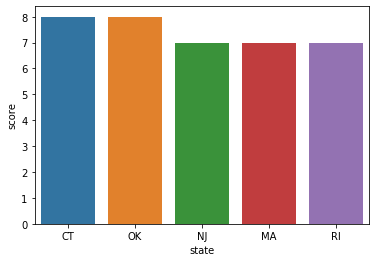

In [43]:
#Top 5 States on Average
sns.barplot(data = max_scores, x = 'state', y='score')
plt.show()

### Connecticut and Oklahoma are tied for the two best states according to Pres